# Part 2. DEAP Dataset + Spectral Analysis + SVM

In this part 2, we will focus on feature engineering using spectral analysis.  Spectral analysis here refers to the analysis of theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 30 Hz), and gamma (30 - 64 Hz).   

Spectral analysis is a very basic and must-do analysis for emotions/cognitions/resting state since it is a common knowledge with abundant evidence that our emotion/cognition change how our brain signals oscillate.  For example, when we are calm, alpha is relatively high, likewise, when we are attentive, beta is relatively high and alpha becomes relatively lower.

In this part, we shall extract these powers as features and then input them into SVM and see if these features are useful for predicting the four valence-arousal classes that we have obtained from Part 1.

In [18]:
import torch

import os
import pickle
import numpy as np

Set cuda accordingly.

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cuda


## 1. Loading dataset

Let's first reuse the dataset loader we have created in Part 1.

In [20]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, path, stim):
        _, _, filenames = next(os.walk(path))
        filenames = sorted(filenames)
        all_data = []
        all_label = []
        for dat in filenames:
            temp = pickle.load(open(os.path.join(path,dat), 'rb'), encoding='latin1')
            all_data.append(temp['data'])
            
            if stim == "Valence":
                all_label.append(temp['labels'][:,:1])   #the first index is valence
            elif stim == "Arousal":
                all_label.append(temp['labels'][:,1:2]) # Arousal  #the second index is arousal
                
        self.data = np.vstack(all_data)[:, :32, ]   #shape: (1280, 32, 8064) --> take only the first 32 channels
        
        shape = self.data.shape
        
        #perform segmentation=====
        segments = 12
        
        self.data = self.data.reshape(shape[0], shape[1], int(shape[2]/segments), segments)
        #data shape: (1280, 32, 672, 12)

        self.data = self.data.transpose(0, 3, 1, 2)
        #data shape: (1280, 12, 32, 672)

        self.data = self.data.reshape(shape[0] * segments, shape[1], -1)
        #data shape: (1280*12, 32, 672)
        #==========================
        
        self.label = np.vstack(all_label) #(1280, 1)  ==> 1280 samples, 
        self.label = np.repeat(self.label, 12)[:, np.newaxis]  #the dimension 1 is lost after repeat, so need to unsqueeze (1280*12, 1)
        
        del temp, all_data, all_label

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        single_data  = self.data[idx]
        single_label = (self.label[idx] > 5).astype(float)   #convert the scale to either 0 or 1 (to classification problem)
        
        batch = {
            'data': torch.Tensor(single_data),
            'label': torch.Tensor(single_label)
        }
        
        return batch

Let's try load the dataset.

In [21]:
path = "data"  #create a folder "data", and inside put s01.dat,....,s32.dat inside from the preprocessed folder from the DEAP dataset

In [22]:
dataset = Dataset(path, "Valence")

data  = dataset[:]['data']
label = dataset[:]['label']

print("Data shape: " , data.shape)  #15360 = 32 participants * 40 trials * 12 segments, 32 EEG channels, 672 samples
print("Label shape: ", label.shape)  #two classes of valence
print(f"{sum(label==0)=} + {sum(label==1)=} = {sum(label==0)+sum(label==1)}")

del(data,label)

Data shape:  torch.Size([15360, 32, 672])
Label shape:  torch.Size([15360, 1])
sum(label==0)=tensor([6864]) + sum(label==1)=tensor([8496]) = tensor([15360])


## 2. Spectral Analysis

Recall to the [dataset meta data ](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/readme.html#prep), the following information is relevant to us.

- sample rate: 128Hz
- Channels: 32
  1.	Fp1	
  2.	AF3
  3.	F3
  4.	F7
  5.	FC5
  6.	FC1
  7.	C3
  8.	T7
  9.	CP5
  10.	CP1
  11.	P3
  12.	P7
  13.	PO3
  14.	O1
  15.	Oz
  16.	Pz
  17.	Fp2
  18.	AF4
  19.	Fz
  20.	F4
  21.	F8
  22.	FC6
  23.	FC2
  24.	Cz
  25.	C4
  26.	T8
  27.	CP6
  28.	CP2
  29.	P4
  30.	P8
  31.	PO4
  32.	O2

For this task, we wil be using [Python MNE library](https://mne.tools/stable/index.html)

In [23]:
import mne
mne.sys_info()
# Note that at the time this jupytor is created, the version of MNE is 0.24.1

# Additional libraries that I use are
# - sklearn
# - psutil
# - pandas
# - matplotlib
# Their version is as followed

Platform:       Linux-5.10.16.3-microsoft-standard-WSL2-x86_64-with-glibc2.29
Python:         3.8.10 (default, Nov 26 2021, 20:14:08)  [GCC 9.3.0]
Executable:     /root/projects/.venv/bin/python
CPU:            x86_64: 16 cores
Memory:         15.4 GB

mne:            0.24.1
numpy:          1.22.3 {}
scipy:          1.8.0
matplotlib:     3.5.1 {backend=module://matplotlib_inline.backend_inline}

sklearn:        1.0.2
numba:          Not found
nibabel:        Not found
nilearn:        Not found
dipy:           Not found
cupy:           Not found
pandas:         1.4.1
mayavi:         Not found
pyvista:        Not found
pyvistaqt:      Not found
ipyvtklink:     Not found
vtk:            Not found
PyQt5:          Not found
ipympl:         Not found
mne_qt_browser: Not found
pooch:          Not found


First, you need to understand MNE philosophy.

In EEG-like experiment, you usually have a session. (1 record)

The data you usually have is in a form of (channels, samples)

For instance, if you record EEG with 16 channels, sample rate of 128 Hz, and 5 seconds long then you would end up with a session in a shape of (16, 128 x 5). Sort of.

It is very common that we also have addition channels like EOG, ECG, MEG, EMG, and many more ..G so the number of channel can be vary. One addition channel we record is `marker`.

A `marker` is sort of mapper during the record to later identify when does something happen.

For instance, if you are recording an EEG data that a participant watch a series of images. You might want to also embeded the information when does the image change or even better, the current shown show.

Let's say there is two images. A data with 3 EEG chanels + marker will might look like this

```
[
 .
 .
 .
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 1], <----- The image 1 is shown now
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 2], <----- The image 2 is shown now
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 .
 .
 .
]
```


When you load the data to MNE, there are three data structures MNE has which corresponding to the analysis needs.

https://mne.tools/stable/most_used_classes.html

1. MNE.io.Raw
  - The `MNE.io.Raw` is you entire session. In this class, you can perform a preprocess for the entire session like `filter`
2. MNE.Epochs
  - The Epochs is an idea for segment the entire session to smaller windows. You can epoching you session in any how you like. The most common epoching is follow the `marker/event` channel
3. MNE.Evoked
  - Evoked is a data that you obtain from each epochs. 

You can think of the Epochs is an Array of Evoked.


From our Dataset above, the data is in a form of Epochs so we can create an Epochs Object.

In [24]:
ch_names = ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
ch_types = ['eeg'] * len(ch_names)
sfreq = 128 #Hz
# https://mne.tools/stable/generated/mne.create_info.html
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)
epochs = mne.EpochsArray(dataset[:]['data'],info)
epochs.set_montage('standard_1020')
print('----')
# You can access the original data using <>._data 
print(f"{epochs._data.shape=}")
print('----')
epochs

Not setting metadata
Not setting metadata
15360 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
----
epochs._data.shape=(15360, 32, 672)
----


Number of events,15360
Events,1: 15360
Time range,0.000 – 5.242 sec
Baseline,off


Here is how the epochs and evoked differ.

In [25]:
# Thier shape is different. 
print(type(epochs.__getitem__(0)),  epochs.__getitem__(0)._data.shape )

for evoked in epochs.iter_evoked():
    print(type(evoked), evoked.get_data().shape)
    break

# There attribute/meta is different
print(evoked)
epochs.__getitem__(10)

<class 'mne.epochs.EpochsArray'> (1, 32, 672)
<class 'mne.evoked.EvokedArray'> (32, 672)
<Evoked | '1' (average, N=1), 0 – 5.2422 sec, baseline off, 32 ch, ~217 kB>


Number of events,1
Events,1: 1
Time range,0.000 – 5.242 sec
Baseline,off


Base on the information given in the DEAP website, the preprocessed data has done the following;

1. The data was downsampled to 128Hz.
2. EOG artefacts were removed as in [1].
3. A bandpass frequency filter from 4.0-45.0Hz was applied.
4. The data was averaged to the common reference.
5. The EEG channels were reordered so that they all follow the Geneva order as above.
6. The data was segmented into 60 second trials and a 3 second pre-trial baseline removed.
7. The trials were reordered from presentation order to video (Experiment_id) order.

Let's take a quick look at the data

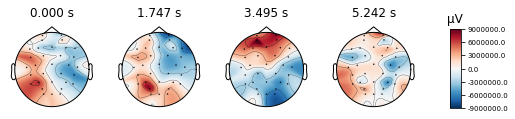

-----
Creating RawArray with float64 data, n_channels=32, n_times=672
    Range : 0 ... 671 =      0.000 ...     5.242 secs
Ready.
Effective window size : 5.250 (s)


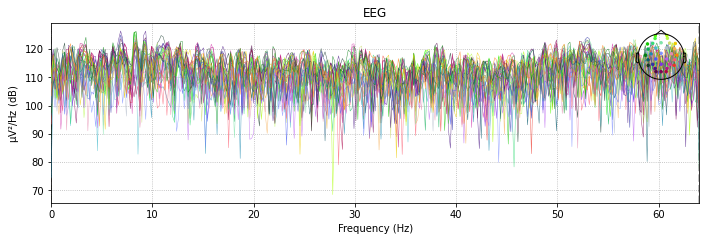

-----
    Using multitaper spectrum estimation with 7 DPSS windows


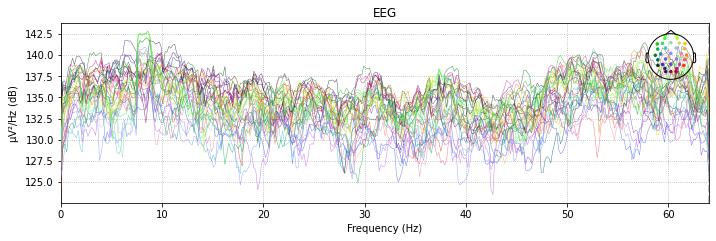

-----
    Using multitaper spectrum estimation with 7 DPSS windows


/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: Deprecat

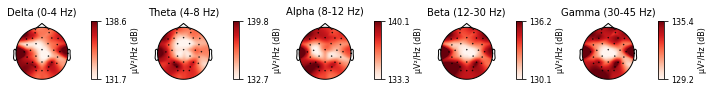

In [26]:
for evoked in epochs.iter_evoked():
    # Plot a topomap from two different method
    evoked.plot_topomap()
    print('-----')
    # Here we plot Power Spectral Density using two different method
    raw = mne.io.RawArray(evoked.get_data(),info=info)
    raw.set_montage('standard_1020')
    raw.plot_psd()
    print('-----')
    epochs.__getitem__(0).plot_psd()
    print('-----')
    epochs.__getitem__(0).plot_psd_topomap()
    break

## Extracting PSD feature

MNE has functions to calulate PSD. There are multiple methods to get PSD from a signal (and other Voltage-to-Frequency domain convert technique).

A welch method is widely used (based on papers I read). 

These are Signal Processing technique. 

For now, I will used MNE built-in function. (Look out for all the parameters this function accept when you are reading any paper)
https://mne.tools/stable/generated/mne.time_frequency.psd_welch.html

In [27]:
epoch = epochs.__getitem__(0)
psds, freqs = mne.time_frequency.psd_welch(epoch)
# print(psds.shape, freqs.shape) => (1, 32, 129) (129,)

print(freqs)

Effective window size : 2.000 (s)
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5
 49.  49.5 50.  50.5 51.  51.5 52.  52.5 53.  53.5 54.  54.5 55.  55.5
 56.  56.5 57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  61.5 62.  62.5
 63.  63.5 64. ]


`psd_welch` returns you two objects, PSDs and FREQs.

The shape of PSDs is (n_epochs,n_channels,n_freqs) and FREQs is (n_freqs)

As you can see, the range of frequency returned from the function is [0-64] because of nyquist theory. (Oh no, more theory)

The basic is you can only obtain frequncy range up to sampling_rate/2. In this data, the sampling rate/freq is 128Hz, therefor the maximun frequncy is 128/2 = 64 Hz

In [28]:
epoch = epochs.__getitem__(0)
psds, freqs = mne.time_frequency.psd_welch(epoch, n_fft=128)
# print(psds.shape, freqs.shape) => (1, 32, 65) (65,)

print(freqs)

Effective window size : 1.000 (s)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64.]


The default `n_fft` is 256. Now that we change the `n_fft` to 128 (matching with sampling rate), the returned FREQs has [0-64] range and a shape of (65,) instead of (129,0).

We can say that more `n_fft`, more resolution.


I will stick with `n_fft=128` to eliminate the headache of mapping array index with freq value (I'm lazy, sorry)

In [29]:
# Note that now I use `epochs`
psds, freqs = mne.time_frequency.psd_welch(epochs, n_fft=128)
psds = 10 * np.log10(psds)
print(psds.shape, freqs.shape)

Effective window size : 1.000 (s)
(15360, 32, 65) (65,)


## Convert to X,y

There are multiple ways we can convert from `PSDs` to `X` (features,Independent Variable, whatever name you want to call).

This depends on your theory/hypothesis, data size, and try/experiment what works best on your topic.

The simplest way to think is a stimuli causes Alpha, Beta, ... the entire brain. Therefore, we will summarize `(_, 32,65)` to `(_,65)`.

We can also summarize the `(_,65)` to `(_,5)` delta (0-4), theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 30 Hz), and gamma (30 - 64 Hz)

**Note that the range of delta,theta,... is different from paper to paper*

In [30]:
X_65 = psds.mean(axis=1)
print(X_65.shape)

# I am going to save this because it takes long time to get this data.
with open(f'cache/X_65.pickle', 'wb') as handle:
    pickle.dump(X_65, handle, protocol=pickle.HIGHEST_PROTOCOL)

(15360, 65)


In [31]:
bands = [(0,4), (4,8), (8,12), (12,30), (30,64)]

X_5 = []
for band in bands:
    # Make copy just in case. Bad habbit, 
    selected_band = X_65[:,band[0]:band[1]+1].copy()
    # Bad line of code.
    # .mean(axis=1) will extract that target band into one number
    # the shape is (n_sample,) and it won't let we .hstack. Therefore, I has to make it (n_sample, 1)
    X_5.append(np.expand_dims(selected_band.mean(axis=1), axis=1))

X_5 = np.hstack(X_5)
print(X_5.shape)

# I am going to save this because it takes long time to get this data.
with open(f'cache/X_5.pickle', 'wb') as handle:
    pickle.dump(X_5, handle, protocol=pickle.HIGHEST_PROTOCOL)

(15360, 5)


In [32]:
y = np.array(dataset[:]['label'])
print(y.shape)

# sklearn SVM accepts y array in shape of (n_samples,)
y = y.squeeze()
print(y.shape)

# Save!!!!!!!
with open(f'cache/y_valence.pickle', 'wb') as handle:
    pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

(15360, 1)
(15360,)


## 3. Machine Learning

*You may restart the kernel and run fron this cell*

In [33]:
import pickle
def load(path):
    with open(path, 'rb') as handle:
        data = pickle.load(handle)
    return data

# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# SVM has many kernels. We could use any but searching the best kernel can also be done.
def grid_search(X_ori, y_ori):
    # Make a copy because I am paranoid
    X,y = X_ori.copy(), y_ori.copy()
    from sklearn.svm import SVC
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    param_grid = dict(kernel=['linear','poly','rbf', 'sigmoid'])
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(SVC(max_iter=10000), param_grid=param_grid, cv=cv)
    grid.fit(X, y)
    return grid

In [34]:
# I gave up. I run this for 100 minutes and it not even finish the first gridSearch
import time
start = time.time()
grid_65 = grid_search(load("cache/X_65.pickle"), load("cache/y_valence.pickle"))
print("Time consumed in working: ",time.time() - start)
with open(f'cache/grid_65.pickle', 'wb') as handle:
    pickle.dump(grid_65, handle, protocol=pickle.HIGHEST_PROTOCOL)


start = time.time()
grid_5 = grid_search(load("cache/X_5.pickle"), load("cache/y_valence.pickle"))
print("Time consumed in working: ",time.time() - start)
with open(f'cache/grid_5.pickle', 'wb') as handle:
    pickle.dump(grid_5, handle, protocol=pickle.HIGHEST_PROTOCOL)

/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: S

Time consumed in working:  122.46016931533813


/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: S

Time consumed in working:  75.84154176712036


/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [35]:
print(grid_65.best_params_,grid_65.best_score_)
print(grid_5.best_params_,grid_5.best_score_)

{'kernel': 'rbf'} 0.6264322916666666
{'kernel': 'rbf'} 0.5658854166666666


The grid_search found `rbf` to be the best kernel. However, majority of the training is not even converge (even we did StandardScala). Without `max_iter`, it won't finish even after 100 minute of waiting. This dataset is harder than a simple Spectral Analysis can handle.

However, let's explore a bit more.

Below, I wrote my own grid_search

In [36]:
def train_model(X_ori,y_ori, kernel='rbf'):
    # Make a copy because I am paranoid
    X,y = X_ori.copy(), y_ori.copy()

    from sklearn.svm import SVC
    from sklearn.utils import shuffle
    from sklearn.model_selection import cross_val_score

    # 
    X_shuff,y_shuff = shuffle(X,y)
    model = SVC(kernel=kernel,max_iter=10000)
    cross = cross_val_score(model, X_shuff, y_shuff, cv=3)

    model = SVC(kernel=kernel, max_iter=10000)
    model.fit(X_shuff, y_shuff)
    ans = model.predict(X_shuff)
    acc = sum(ans == y_shuff) / len(y_shuff)
    return model, acc, cross

In [37]:
import time
for kernel in ['linear','poly','rbf', 'sigmoid']:
    start = time.time()
    model, acc, cross = train_model(load("cache/X_65.pickle"), load("cache/y_valence.pickle"), kernel=kernel)
    # We can save the model and reuse it later
    print(f"\tKernel={kernel}| Acc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


	Kernel=linear| Acc=0.46471 | 3-CV score=0.52871 STD=0.01189| Time spend=6.751644849777222


/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


	Kernel=poly| Acc=0.61986 | 3-CV score=0.56094 STD=0.01317| Time spend=28.53457498550415
	Kernel=rbf| Acc=0.64453 | 3-CV score=0.61517 STD=0.00353| Time spend=42.964158058166504
	Kernel=sigmoid| Acc=0.47533 | 3-CV score=0.49499 STD=0.02772| Time spend=26.931114435195923


In [38]:
import time
for kernel in ['linear','poly','rbf', 'sigmoid']:
    start = time.time()
    model, acc, cross = train_model(load("cache/X_5.pickle"), load("cache/y_valence.pickle"), kernel=kernel)
    # We can save the model and reuse it later
    print(f"\tKernel={kernel}| Acc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


	Kernel=linear| Acc=0.50521 | 3-CV score=0.53398 STD=0.01753| Time spend=10.767875671386719


/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


	Kernel=poly| Acc=0.56914 | 3-CV score=0.55345 STD=0.00509| Time spend=15.865894079208374


/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


	Kernel=rbf| Acc=0.57044 | 3-CV score=0.56725 STD=0.00745| Time spend=23.279263973236084
	Kernel=sigmoid| Acc=0.47174 | 3-CV score=0.47051 STD=0.00304| Time spend=17.749394416809082


Finally, we have some result.

The score we get is about 55% accuracy (even with 100% training data). Based on the features we exracted, it seems that SVM can not differentiate the valence data.


**Note: I did my second run with `psds = 10 * np.log10(psds)` and the X_65 got a better ACC and CV from 60 to 65 and 59 to 61 with `rbf` kernel. The challenge is to find a combination of technique that will gain a better score without biasing the data (is that even a word `biasing`)*